In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
# from langchain_chroma import Chroma
from langchain.vectorstores import FAISS
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [3]:
# price is a factor for our company, so we're going to use a low cost model

from openai import OpenAI
MODEL = "llama3.2"
openai = OpenAI(base_url="http://localhost:11434/v1", api_key="ollama")

# MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [4]:
# Load environment variables in a file called .env

# load_dotenv(override=True)
# os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [5]:
# Read in documents using LangChain's loaders

folders = glob.glob("knowledge-base/*")

text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [6]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [7]:
len(chunks)

123

In [8]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: company, contracts, employees, products


In [10]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk


# embeddings = OpenAIEmbeddings() #uncomment if using Open AI API
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create vectorstore

# BEFORE
# vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)

# AFTER
vectorstore = FAISS.from_documents(chunks, embedding=embeddings)

total_vectors = vectorstore.index.ntotal
dimensions = vectorstore.index.d

print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in the vector store")

C:\Users\dasha\AppData\Local\Temp\ipykernel_28828\2823415217.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


There are 123 vectors with 384 dimensions in the vector store


In [11]:
# Prework
vectors = []
documents = []
doc_types = []
colors = []
color_map = {'products':'blue', 'employees':'green', 'contracts':'red', 'company':'orange'}

for i in range(total_vectors):
    vectors.append(vectorstore.index.reconstruct(i))
    doc_id = vectorstore.index_to_docstore_id[i]
    document = vectorstore.docstore.search(doc_id)
    documents.append(document.page_content)
    doc_type = document.metadata['doc_type']
    doc_types.append(doc_type)
    colors.append(color_map[doc_type])
    
vectors = np.array(vectors)

C:\Users\dasha\anaconda3\envs\llms\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


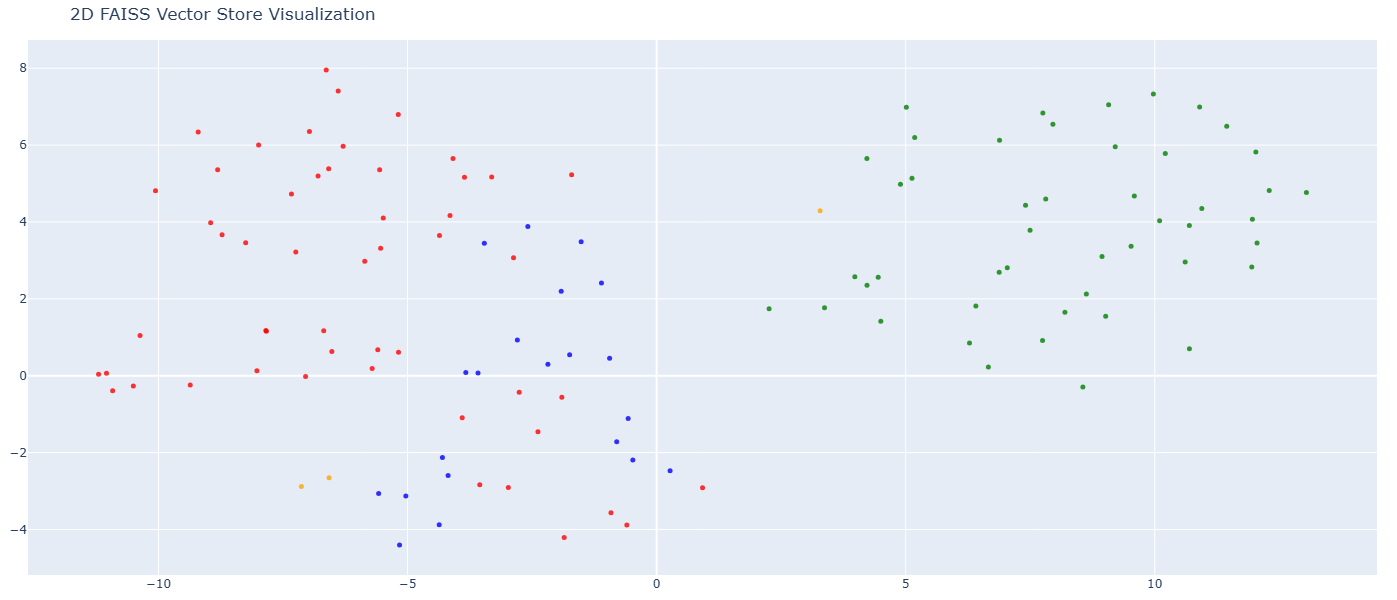

In [12]:
# We humans find it easier to visalize things in 2D!

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

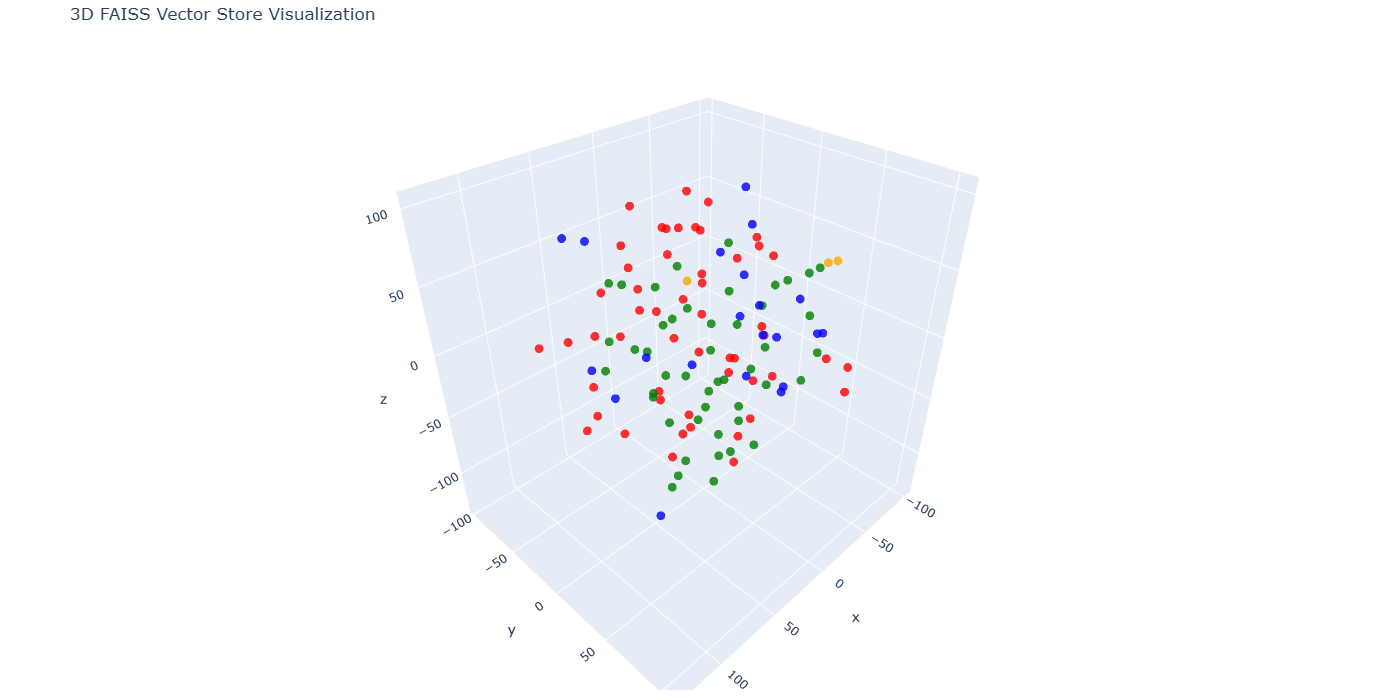

In [13]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()